<a href="https://colab.research.google.com/github/JamieCDev20/GAM705/blob/main/705Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

Imports

In [1]:
!pip install pyquaternion
!pip install PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os
from pyquaternion import Quaternion
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from random import random as r
import matplotlib.pyplot as plt
import time

In [3]:
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

File Reader

In [4]:
class AnimFileReader():
  ## "#" breaks between nodes | ":" breaks between values

  def __init__(self, _path):
    self.path = _path
    self.animData = np.array(float)
    self.__ReadAnim__(self.path)

  def __ReadAnim__(self, path):
    file = open(path, 'r')
    overallData = file.read()
    overallData = overallData.split("SS")
    
    del overallData[0]

    jointCount = len(overallData)
    frameCount = len(overallData[0].split('#')[0].split(':')) - 1
    
    dataLayer = np.array(float)

    trainingData = np.array(float)

    for j in range(0, frameCount):
      for i in range(0, jointCount):

        rots = overallData[i].split('#')[0].split(':')
        poss = overallData[i].split('#')[1].split(':')

        del rots[0]
        del poss[0]

        #print(len(rots))
        #print(rots[0], rots[1], rots[2], rots[3])
        #print(dataLayer.shape)
        temp = rots[j].split(',')
        dataLayer = np.append(dataLayer, temp)
        
        temp = poss[j].split(',')
        dataLayer = np.append(dataLayer, temp)
        #print(dataLayer.shape)
      dataLayer = np.delete(dataLayer, 0)
      trainingData = np.append(trainingData, dataLayer);
      dataLayer = np.array(float)
      print("Completed: ", j + 1)

    print("Total its: ", (i + 1) * (j + 1))
    
    trainingData = np.delete(trainingData, 0)
    
    print(trainingData.shape)
    print(trainingData[0])
    
    self.animData = trainingData;
   

#File Read

In [ ]:
fr = AnimFileReader("SHO_EXORCISMWALK_1_UNCLEAN.txt")

In [ ]:
data = fr.animData
print(fr.animData.shape)
print(data.shape)
data = np.reshape(data, [221, 168])
print(fr.animData.shape)
print(data.shape)

(37128,)
(37128,)
(37128,)
(221, 168)


In [ ]:
network = Sequential(
    Input()
)

Testing

In [ ]:
a = np.array([1, 2, 3, 4, 5], float)
b = np.array([6, 6, 6, 6, 6], float)
c = b-a
b = np.append(b, c);

print(b)


[6. 6. 6. 6. 6. 5. 4. 3. 2. 1.]


#GAN Training

##Training Vars

In [37]:
def Func(x):
  return 0.08 * (x-25)**2

In [38]:
genNoiseDim = 1

In [39]:
batchSize = 64
iterations = 10000

testSeed = np.random.uniform(0, 50, [batchSize, genNoiseDim])

holder = []
for i in range(batchSize):
  holder.append(Func(testSeed[i]))

trueData = np.array(holder)

##Networks

Discriminator

In [40]:
discriminator = Sequential([
    Input(shape=(2)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])
#discriminator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

Generator

In [41]:
generator = Sequential([
      Input(shape=(genNoiseDim)),
      Dense(50, activation='relu', use_bias=True),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])
#generator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

##Training

In [42]:
def GenerateRealBatch(size, _noise):
  batch = []
  for i in range(size):
    batch.append(Func(_noise[i]))
  return np.array(batch)

In [43]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

genOp = tf.keras.optimizers.Adam(1e-4)
discOp = tf.keras.optimizers.Adam(1e-4)

def DiscLossCalculation(realResults, fakeResults):
  fLoss = crossEntropy(tf.zeros_like(fakeResults), fakeResults)
  rLoss = crossEntropy(tf.ones_like(realResults), realResults)
  return fLoss + rLoss

def GenLossCalculation(fakeResults):
  return crossEntropy(tf.ones_like(fakeResults), fakeResults)

In [44]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genOp,
                                 discriminator_optimizer=discOp,
                                 generator=generator,
                                 discriminator=discriminator)

In [45]:
@tf.function
def TrainingStep():
  curNoise = np.random.uniform(0, 50, [batchSize, genNoiseDim])
  realBatch = GenerateRealBatch(batchSize, curNoise)

  with tf.GradientTape() as genGradTape, tf.GradientTape() as discGradTape:
    generatedBatch = generator(curNoise)

    realResult = discriminator(np.append(curNoise, realBatch, 1), training = True)
    fakeResult = discriminator(tf.experimental.numpy.append(curNoise, generatedBatch, 1), training = True)

    genLoss = GenLossCalculation(fakeResult)
    discLoss = DiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTape.gradient(genLoss, generator.trainable_variables)
    discGrads = discGradTape.gradient(discLoss, discriminator.trainable_variables)

    genOp.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOp.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return discLoss, genLoss


In [46]:
def Training(epochs):
  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = TrainingStep()
    
    if (epoch + 1) % 1 == 0:
      ShowPlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    print(dLoss, gLoss)


##Test

In [47]:
def ShowPlot():
  plt.clf()
  plt.scatter(testSeed, generator.predict(testSeed), c="red")
  plt.scatter(testSeed, trueData, c="blue")
  plt.show()

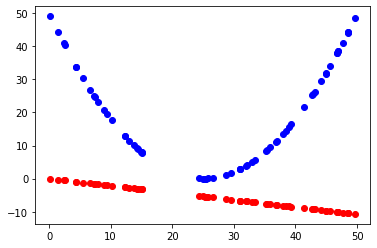

Epoch:  1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


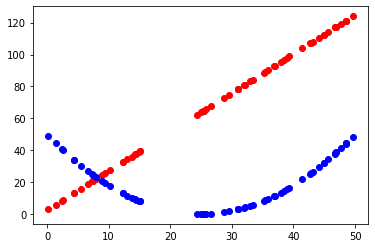

tf.Tensor(0.58909345, shape=(), dtype=float32) tf.Tensor(1.9956023, shape=(), dtype=float32)
Epoch:  2


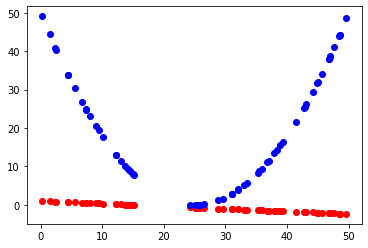

tf.Tensor(1.8407917, shape=(), dtype=float32) tf.Tensor(0.7862697, shape=(), dtype=float32)
Epoch:  3


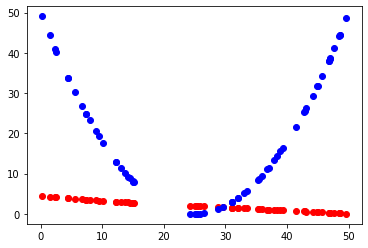

tf.Tensor(1.3484458, shape=(), dtype=float32) tf.Tensor(0.88300645, shape=(), dtype=float32)
Epoch:  4


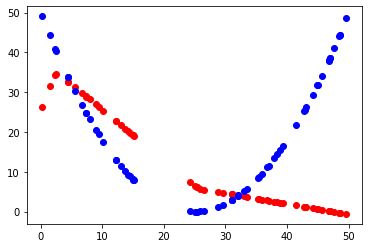

tf.Tensor(1.0725507, shape=(), dtype=float32) tf.Tensor(0.9831563, shape=(), dtype=float32)
Epoch:  5


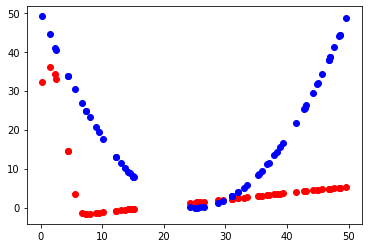

tf.Tensor(1.1878629, shape=(), dtype=float32) tf.Tensor(0.8969288, shape=(), dtype=float32)
Epoch:  6


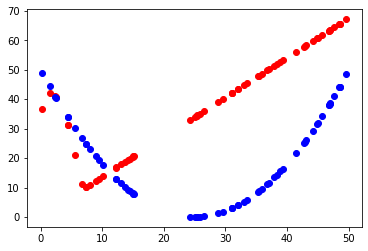

tf.Tensor(0.8125058, shape=(), dtype=float32) tf.Tensor(1.4909801, shape=(), dtype=float32)
Epoch:  7


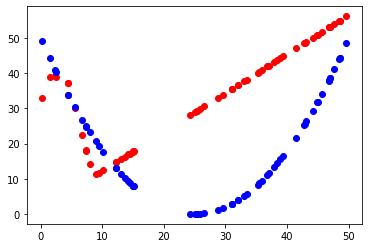

tf.Tensor(1.1539975, shape=(), dtype=float32) tf.Tensor(1.1655005, shape=(), dtype=float32)
Epoch:  8


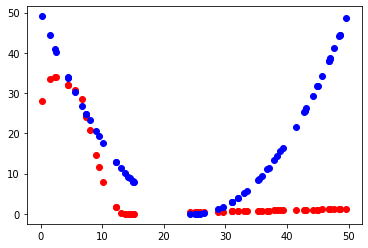

tf.Tensor(1.3768137, shape=(), dtype=float32) tf.Tensor(0.79677784, shape=(), dtype=float32)
Epoch:  9


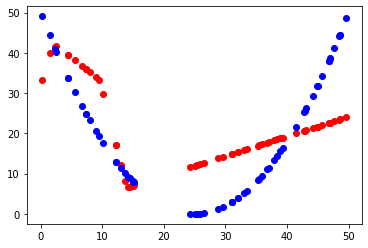

tf.Tensor(1.0749052, shape=(), dtype=float32) tf.Tensor(1.0133457, shape=(), dtype=float32)
Epoch:  10


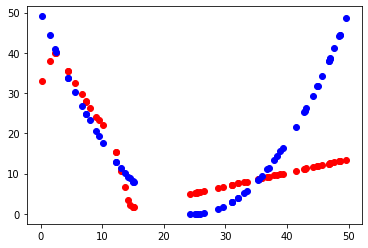

tf.Tensor(1.1196299, shape=(), dtype=float32) tf.Tensor(1.0240246, shape=(), dtype=float32)
Epoch:  11


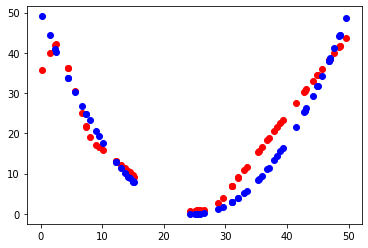

tf.Tensor(1.3621538, shape=(), dtype=float32) tf.Tensor(0.7310488, shape=(), dtype=float32)
Epoch:  12


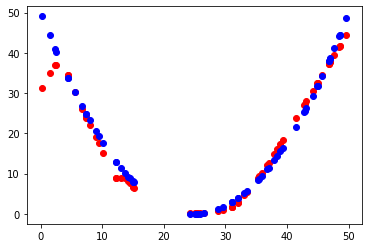

tf.Tensor(1.3832083, shape=(), dtype=float32) tf.Tensor(0.69101804, shape=(), dtype=float32)
Epoch:  13


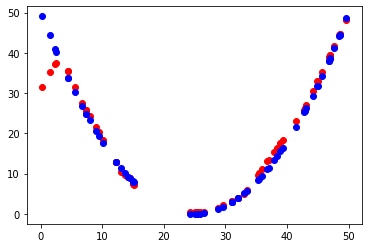

tf.Tensor(1.3794329, shape=(), dtype=float32) tf.Tensor(0.7004312, shape=(), dtype=float32)
Epoch:  14


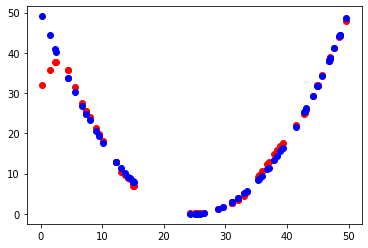

tf.Tensor(1.384989, shape=(), dtype=float32) tf.Tensor(0.6962263, shape=(), dtype=float32)
Epoch:  15


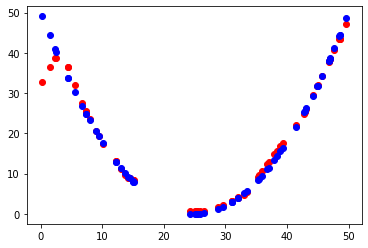

tf.Tensor(1.3807615, shape=(), dtype=float32) tf.Tensor(0.6980992, shape=(), dtype=float32)
Epoch:  16


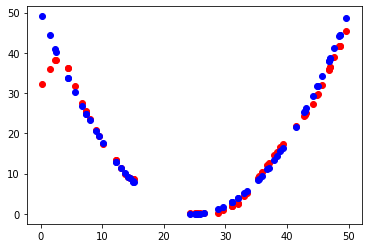

tf.Tensor(1.3818899, shape=(), dtype=float32) tf.Tensor(0.69742393, shape=(), dtype=float32)
Epoch:  17


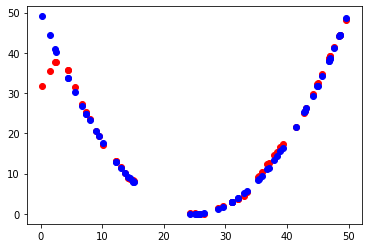

tf.Tensor(1.3839303, shape=(), dtype=float32) tf.Tensor(0.69260585, shape=(), dtype=float32)
Epoch:  18


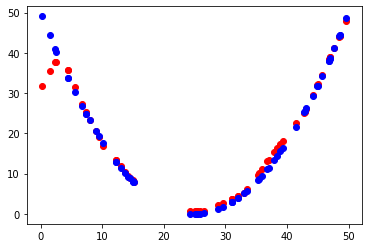

tf.Tensor(1.3770208, shape=(), dtype=float32) tf.Tensor(0.69879854, shape=(), dtype=float32)
Epoch:  19


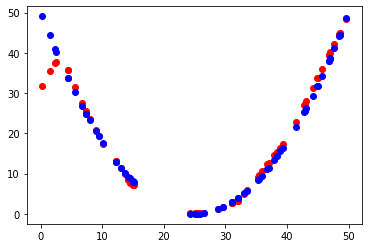

tf.Tensor(1.3841035, shape=(), dtype=float32) tf.Tensor(0.6950642, shape=(), dtype=float32)
Epoch:  20


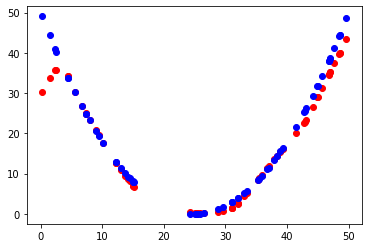

tf.Tensor(1.3788621, shape=(), dtype=float32) tf.Tensor(0.6969482, shape=(), dtype=float32)


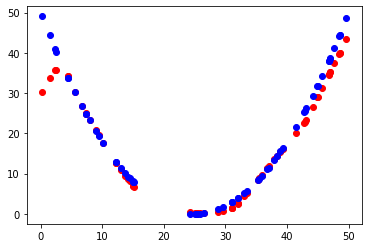

In [48]:
ShowPlot()
Training(20)
ShowPlot()
#checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))
#print(testSeed)
#print(generator.predict(testSeed))

#Accuracy Testing

In [49]:
batch = []
for i in range(1000):
  x = r() * 50
  if i % 2 == 0:
    batch.append([x, generator.predict(np.array([x]))[0][0]])
  else:
    batch.append([x, Func(x)])


In [50]:
results = discriminator.predict(np.array(batch))

In [51]:
print(results)

[[0.4673337 ]
 [0.5106035 ]
 [0.49307907]
 [0.57021064]
 [0.55300605]
 [0.5073728 ]
 [0.55994165]
 [0.48645166]
 [0.4927277 ]
 [0.48710802]
 [0.5122124 ]
 [0.46509093]
 [0.46598056]
 [0.5126345 ]
 [0.48009855]
 [0.55885017]
 [0.4681537 ]
 [0.49810854]
 [0.50087965]
 [0.50751495]
 [0.46231583]
 [0.46382987]
 [0.49538794]
 [0.53023505]
 [0.46737546]
 [0.52671045]
 [0.5240271 ]
 [0.46778923]
 [0.46898845]
 [0.4987963 ]
 [0.4623087 ]
 [0.5161427 ]
 [0.49294305]
 [0.49686056]
 [0.49318892]
 [0.5398616 ]
 [0.4755493 ]
 [0.5015633 ]
 [0.55654347]
 [0.5206387 ]
 [0.46899775]
 [0.5120792 ]
 [0.4586142 ]
 [0.49768227]
 [0.5016203 ]
 [0.51400197]
 [0.46894792]
 [0.5210816 ]
 [0.46021017]
 [0.45145315]
 [0.49237865]
 [0.51276195]
 [0.45961267]
 [0.53648126]
 [0.4651498 ]
 [0.55012065]
 [0.45801625]
 [0.50934935]
 [0.5113004 ]
 [0.51727146]
 [0.46787652]
 [0.5343477 ]
 [0.5565784 ]
 [0.51728004]
 [0.46576437]
 [0.4872755 ]
 [0.5073263 ]
 [0.46791032]
 [0.4650683 ]
 [0.46802664]
 [0.46763122]
 [0.49